<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"> 
        <h1>Applied Probability Theory From Scratch</h1>
        <h1>A/B Testing</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
        @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy import stats

import watermark

%load_ext watermark
%matplotlib inline

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 21.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: ba986396be89a47f327a74e0201e5306334ad07b

scipy     : 1.6.1
seaborn   : 0.11.0
pandas    : 1.1.3
watermark : 2.1.0
matplotlib: 3.3.2
numpy     : 1.19.2
json      : 2.0.9



Set the default style

In [3]:
plt.style.use('./d4sci.mplstyle')

## Simulated data

In [4]:
def get_data(N, pA, pB, fraction=0.5):
    df = pd.DataFrame({'group': (np.random.random(N)<(1-fraction)).astype('int'), 'conversion': 0})
    counts = df.groupby('group').count()
    
    NA = counts.loc[0, 'conversion']
    NB = counts.loc[1, 'conversion']
    
    df.loc[df['group']==0, 'conversion'] = (np.random.random(NA) < pA).astype('int')
    df.loc[df['group']==1, 'conversion'] = (np.random.random(NB) < pB).astype('int')    

    return df

Let's generate some random data. We're assuming two groups of users (chosen at random with probability $1/2$). The first group (control) has a conversion probability $p_A=5\%$ and the new group has a conversion probability $p_B=5.5\%$

In [5]:
pA_theory = 0.05
pB_theory = 0.06
N = 2000
data = get_data(N, pA_theory, pB_theory)

Let's take a look at the "data"

In [6]:
data.head(10)

,group,conversion
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,1,0
8,0,0
9,1,0


## Group averages

conversion=1 means that they bought our product, while conversion=0 means they didn't. We can cheack how many users we have in each group

In [7]:
counts = data.groupby('group').count()
counts

,conversion
group,
0,998
1,1002


And the fraction that converted within each group

In [8]:
means = data.groupby('group').mean()
means

,conversion
group,
0,0.046092
1,0.059880


The conversion fractions are different from the theoretical ones. We can assume that each conversion is an independent process (similar to a coin flip), in which case, we expect that the observed values follow a Binomial distribution.

## Hypothesis Testing

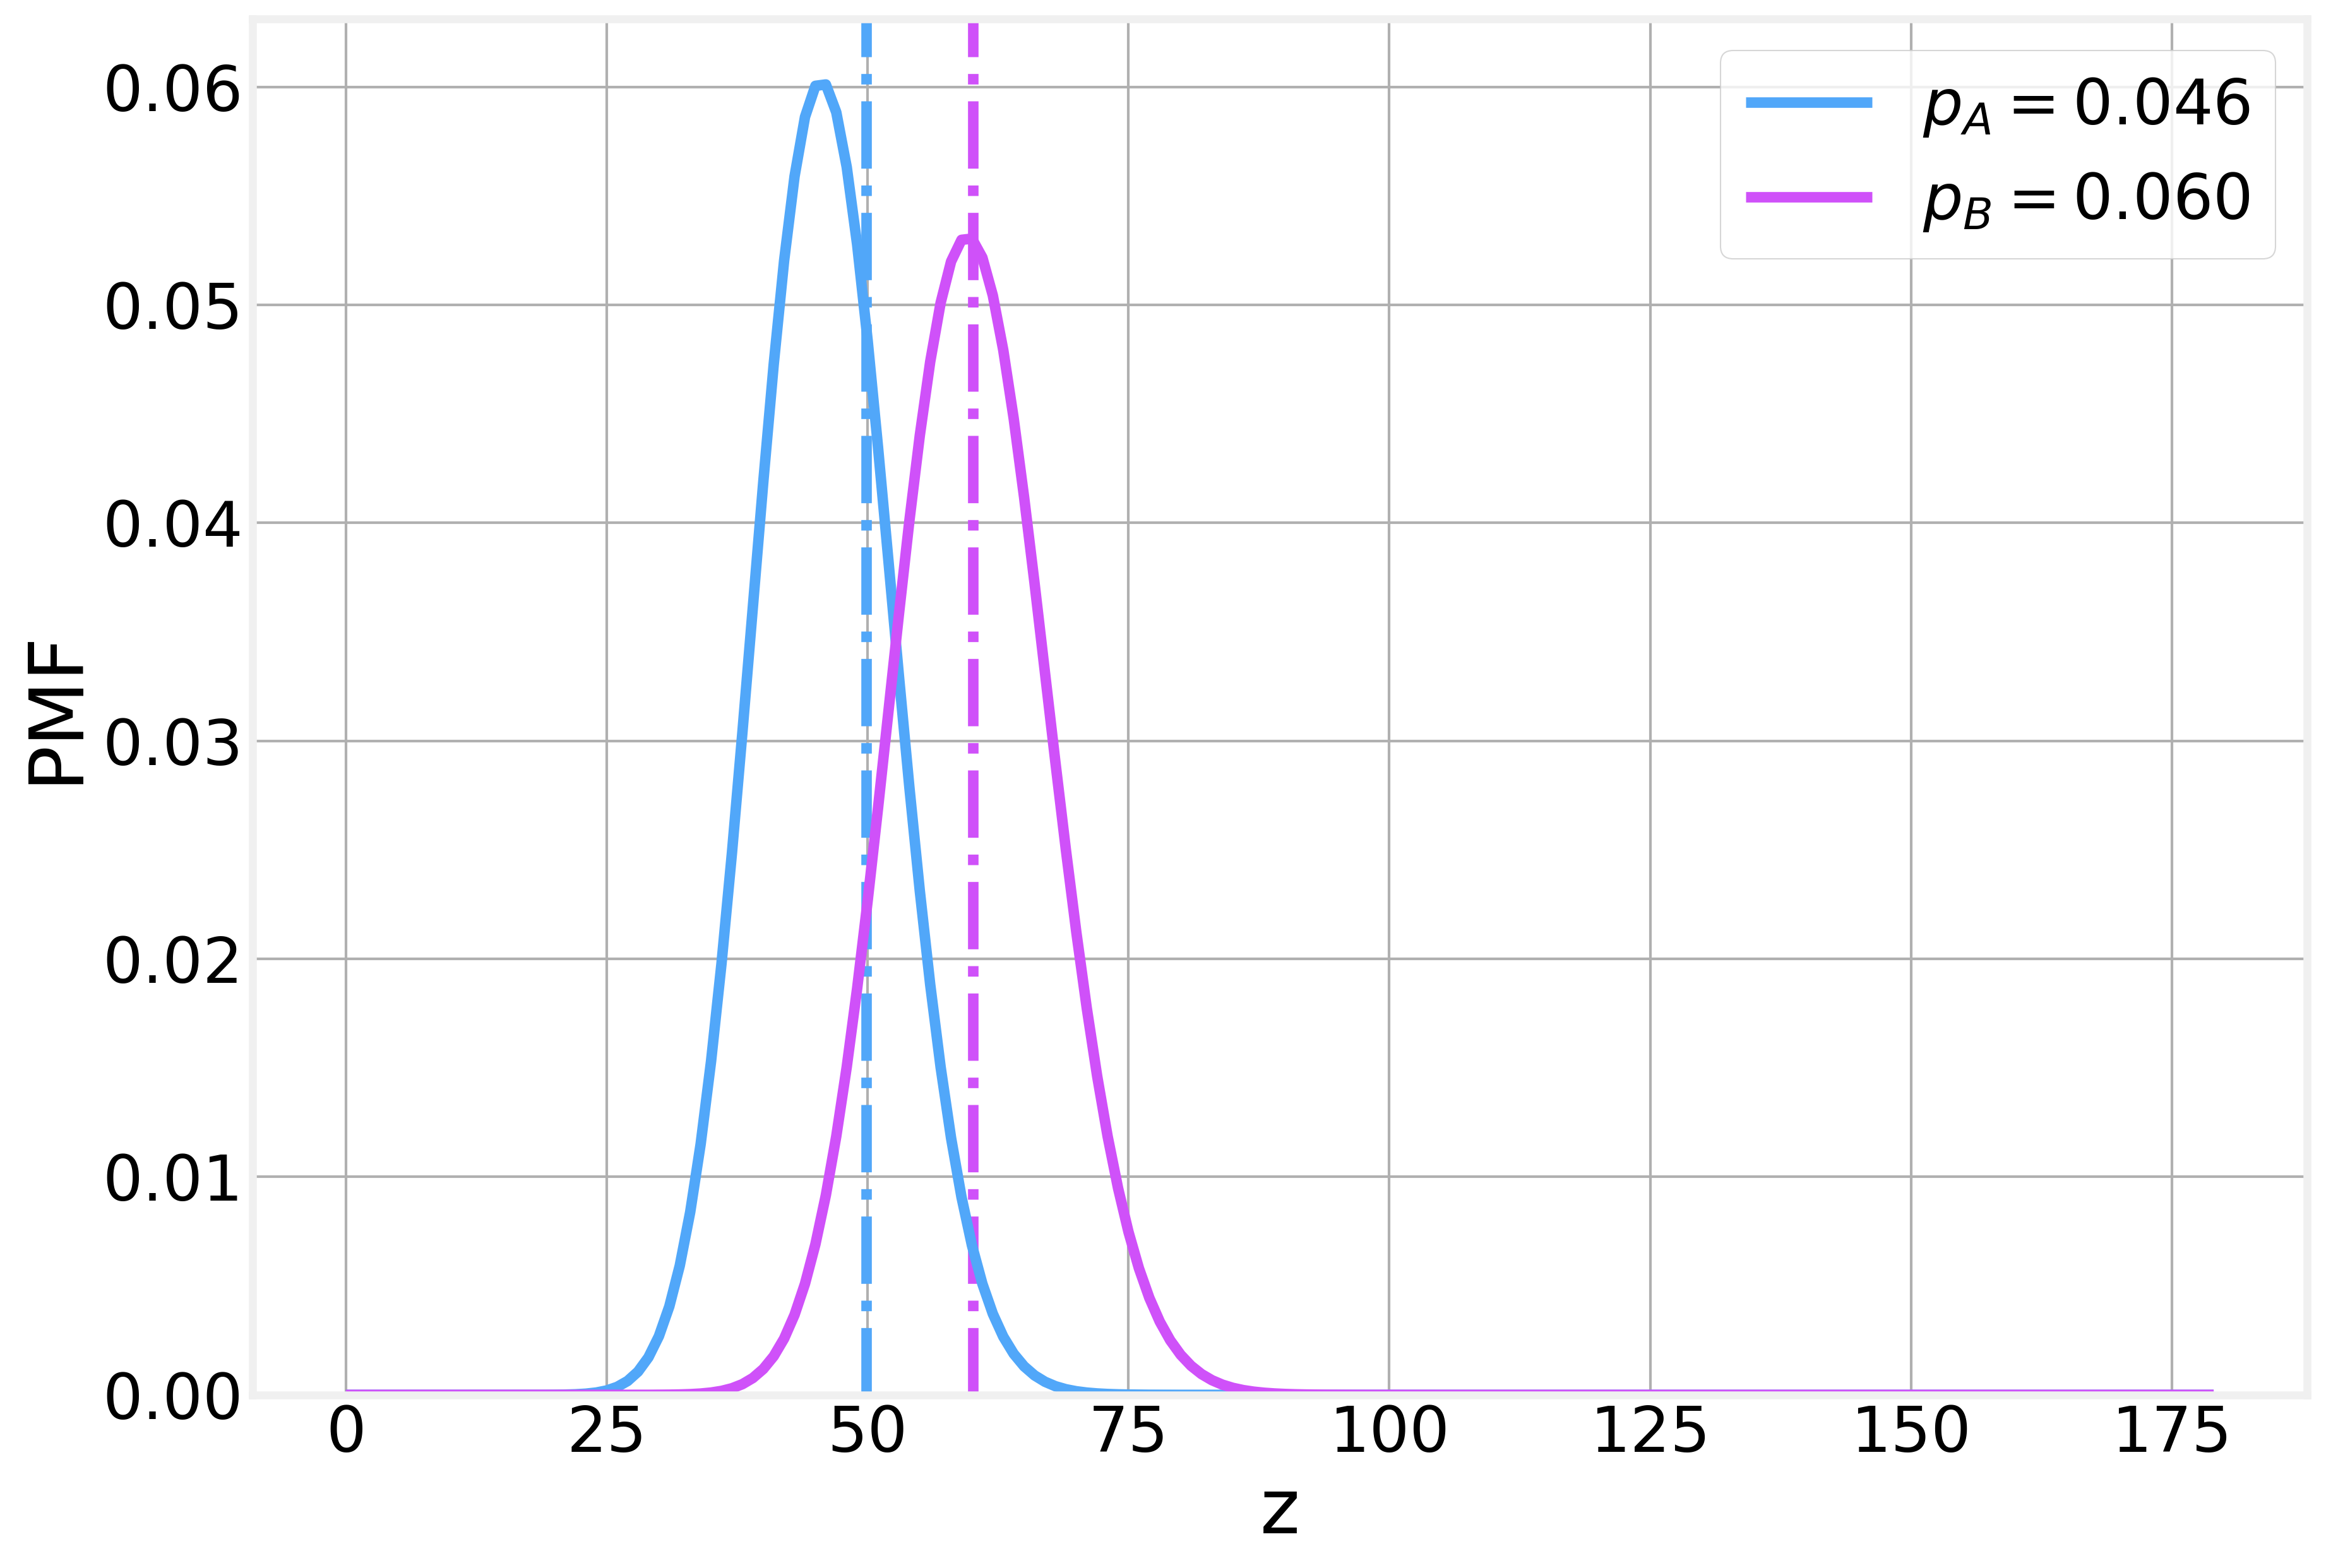

In [9]:
fig, ax = plt.subplots(1, 1)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.set_xlabel('z')
ax.set_ylabel('PMF')

x = np.arange(0, N*pB_theory*1.5)
yA = stats.binom(n=counts.iloc[0, 0], p=means.iloc[0, 0]).pmf(x)
ax.plot(x, yA, label=r'$p_A=%1.3f$' % means.iloc[0])

yB = stats.binom(n=counts.iloc[1, 0], p=means.iloc[1, 0]).pmf(x)
ax.plot(x, yB, label=r'$p_B=%1.3f$' % means.iloc[1])

height = np.max([yA.max(), yB.max()])*1.05

ax.vlines(x=[pA_theory*counts.iloc[0], pB_theory*counts.iloc[1]], ymin=0, ymax=height, colors=colors[:2], linestyles='-.')
ax.set_ylim(0, height)
plt.legend()

This figure clearly illustrates that the observed number of conversions can be significantly differnet from the one we might expect theoretically (as represented by the dashed lines). Indeed, we can take the observed value as an "experimental measurement" of the true value. 

From the central limit theorem, we know that the difference between the true and the experimental values follows a gaussian distribution centered at zero and with a standard deviation given by the standard error of the meaurement. For a Bernoulli process, the standard error is given by

$$SE=\sqrt{\frac{p\left(1-p\right)}{N}}$$

So we can best represent our experimental measurement as

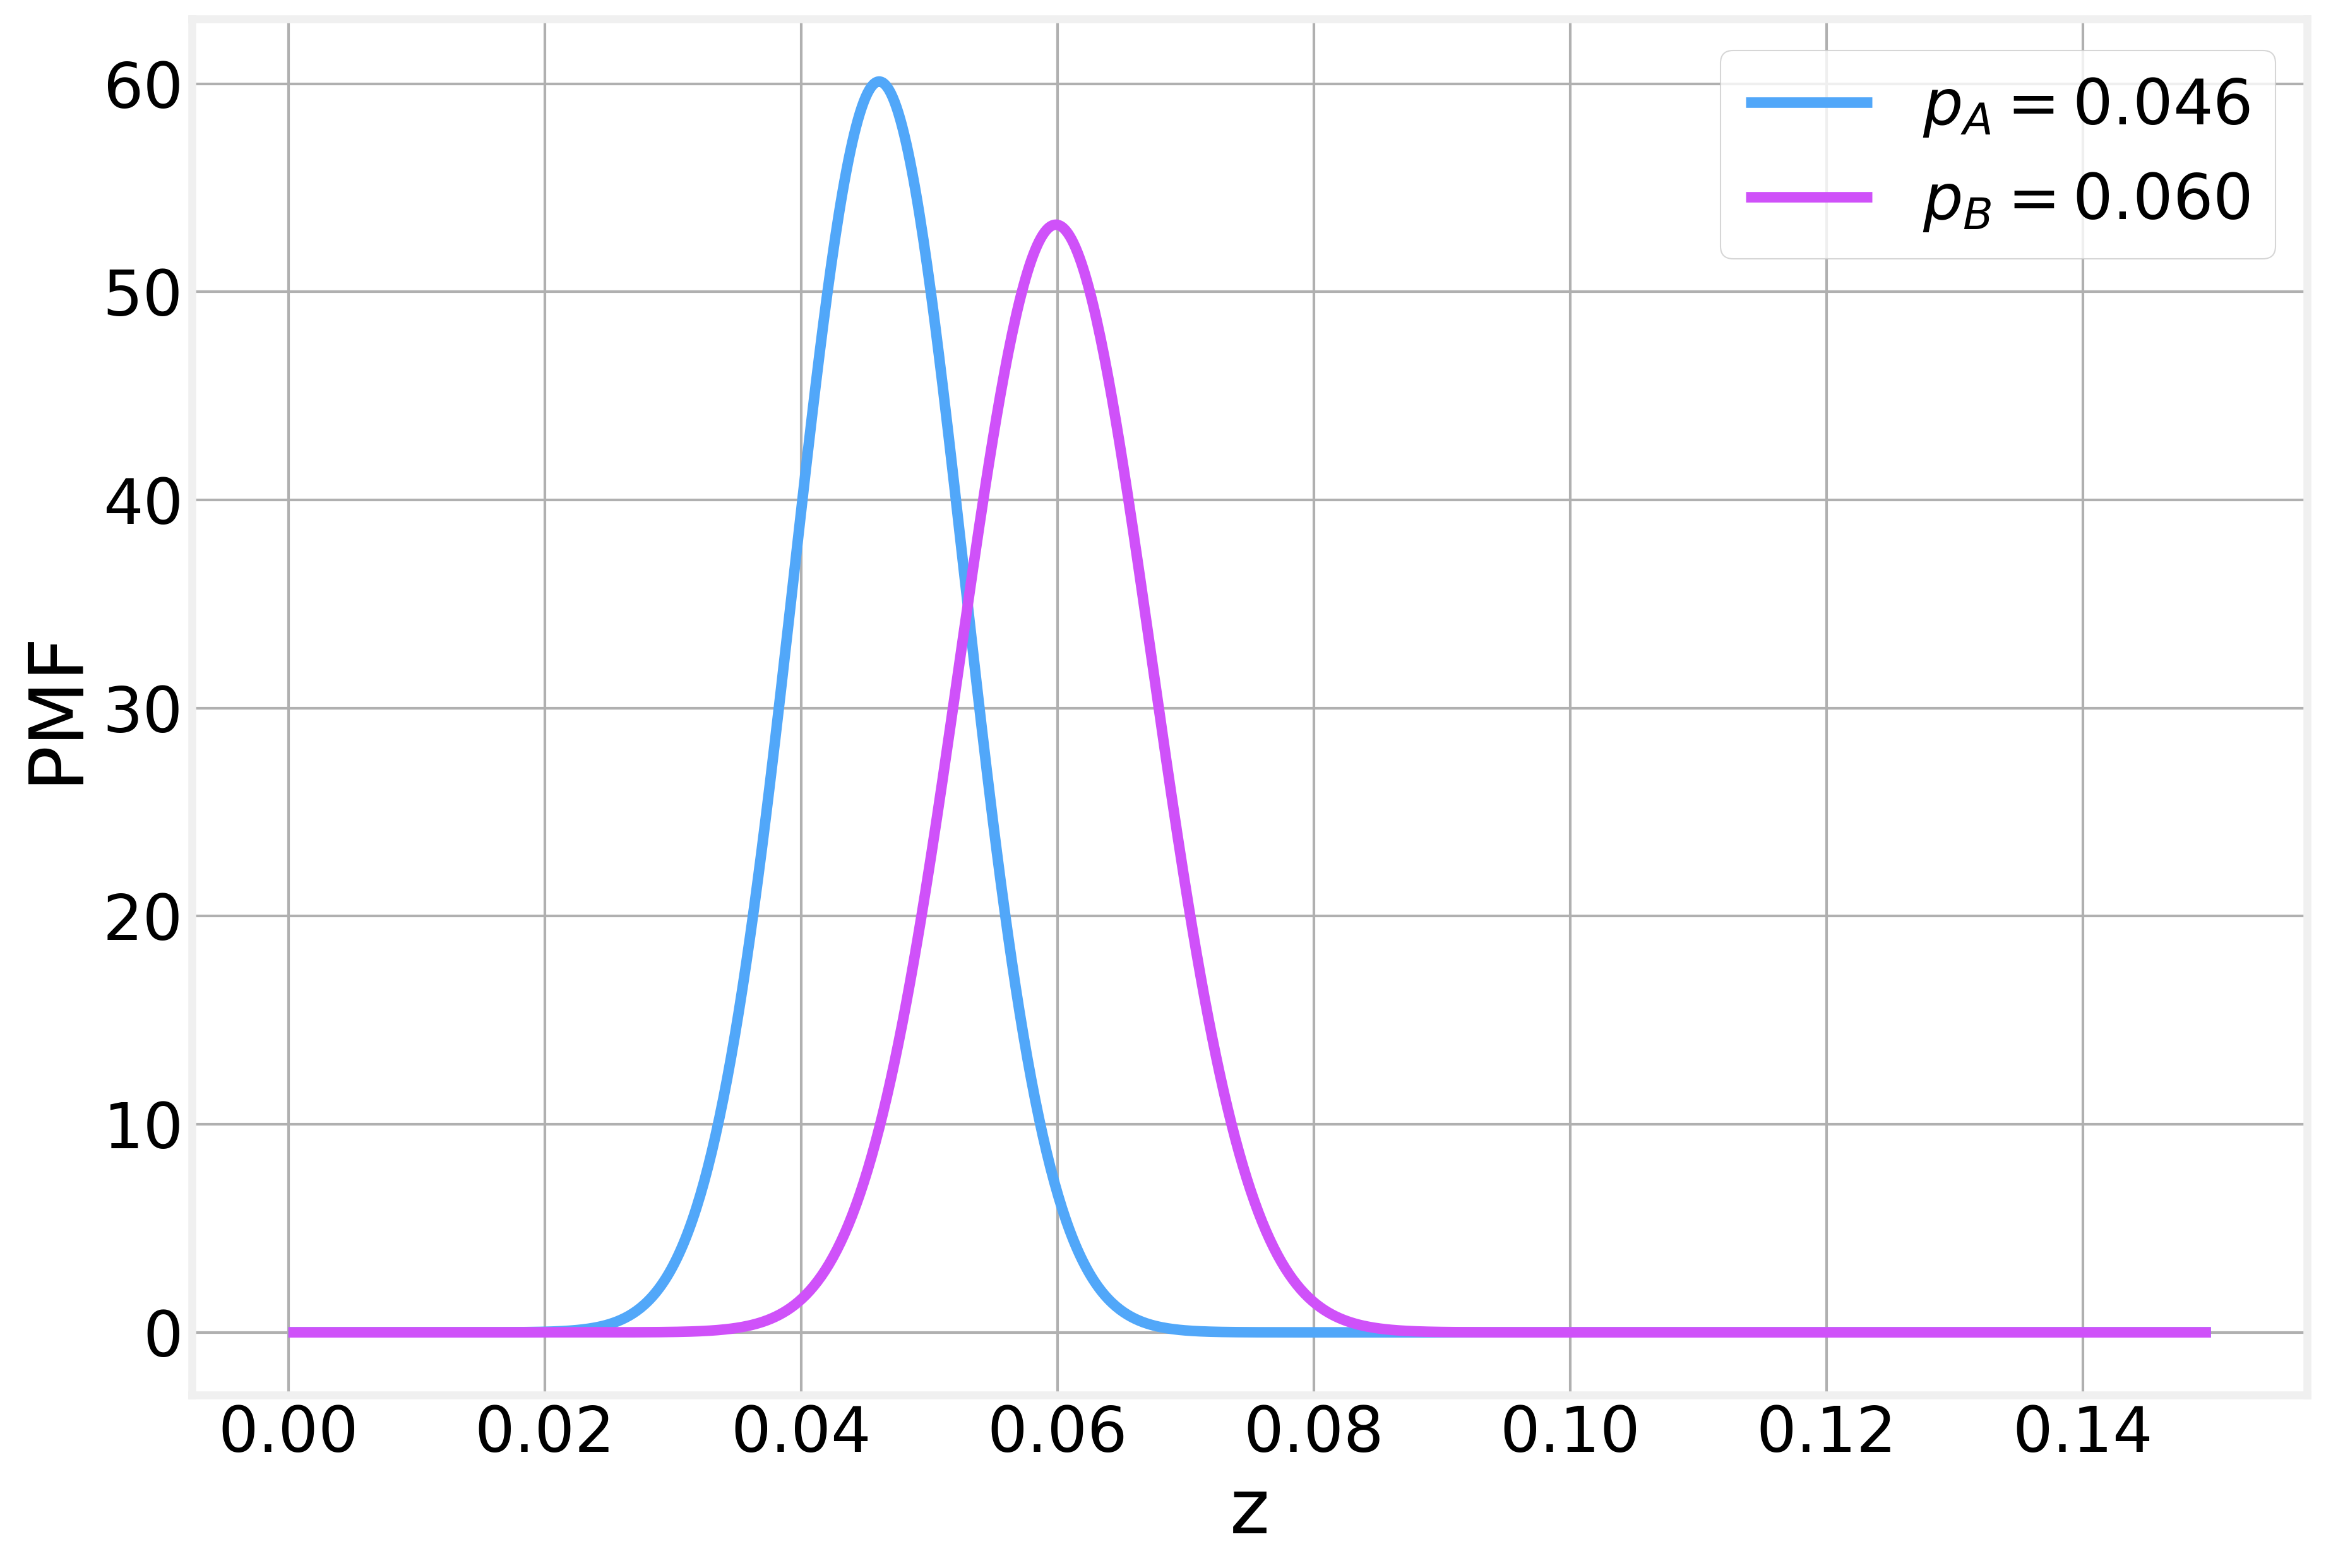

In [10]:
fig, ax = plt.subplots(1, 1)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.set_xlabel('z')
ax.set_ylabel('PMF')

x = np.linspace(0, .15, 1000)
pA = means.iloc[0]
NA = counts.iloc[0]
SEA = np.sqrt(pA*(1-pA)/NA)
yA = stats.norm(pA, SEA).pdf(x)
ax.plot(x, yA, label=r'$p_A=%1.3f$' % pA)

pB = means.iloc[1]
NB = counts.iloc[1]
SEB = np.sqrt(pB*(1-pB)/NB)
yB = stats.norm(pB, SEB).pdf(x)
ax.plot(x, yB, label=r'$p_B=%1.3f$' % pB)
plt.legend()

The corresponding Z score is then given by:

$$Z=\frac{p_B-p_A}{\sqrt{SE_A^2+SE_B^2}}$$

In [11]:
def zscore(pA, pB, NA, NB):
    SEA = np.sqrt(pA*(1-pA)/NA)
    SEB = np.sqrt(pB*(1-pB)/NB)
    return ((pB-pA)/np.sqrt(SEA**2+SEB**2)).values[0]

The Z score for our example is then:

In [12]:
Z = zscore(pA, pB, NA, NB)
print(Z)

1.3771673952191485


We know that Z scores follow a normal distribution centered at zero and unity width. We can use this to calculate the p-values

In [13]:
def pvalue(zscore=2):
    return 1-stats.norm.cdf(zscore)

In [14]:
p = pvalue(Z)
print(p)

0.08423024990161043


We can get an intuitive view of the meaning of the p-value by plotting it in the z-score curve

In [15]:
def plot_zscore(zscore=2):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    norm = stats.norm()
    
    x = np.linspace(-5, 5, 1000)
    y = norm.pdf(x)
    height = y.max()
    
    fig, ax = plt.subplots(1, 1)
    ax.plot(x, y)
    ax.set_xlabel('z')
    ax.set_ylabel('PDF')
    
    p = pvalue(zscore)

    ax.vlines(zscore, 0, height, color=colors[1], linestyle='--')
    ax.text(zscore*1.05, height, "z=%1.2f" % zscore, va="top", ha="left")
    ax.text(zscore*1.05, height*.9, "p=%1.2g" % p, va="top", ha="left")

    selected = x > zscore
    
    ax.fill_between(x, 0, y, color=colors[2], alpha=0.4, where=selected)    
    ax.text(0, height/2, np.round(1-p, 5), ha='center')

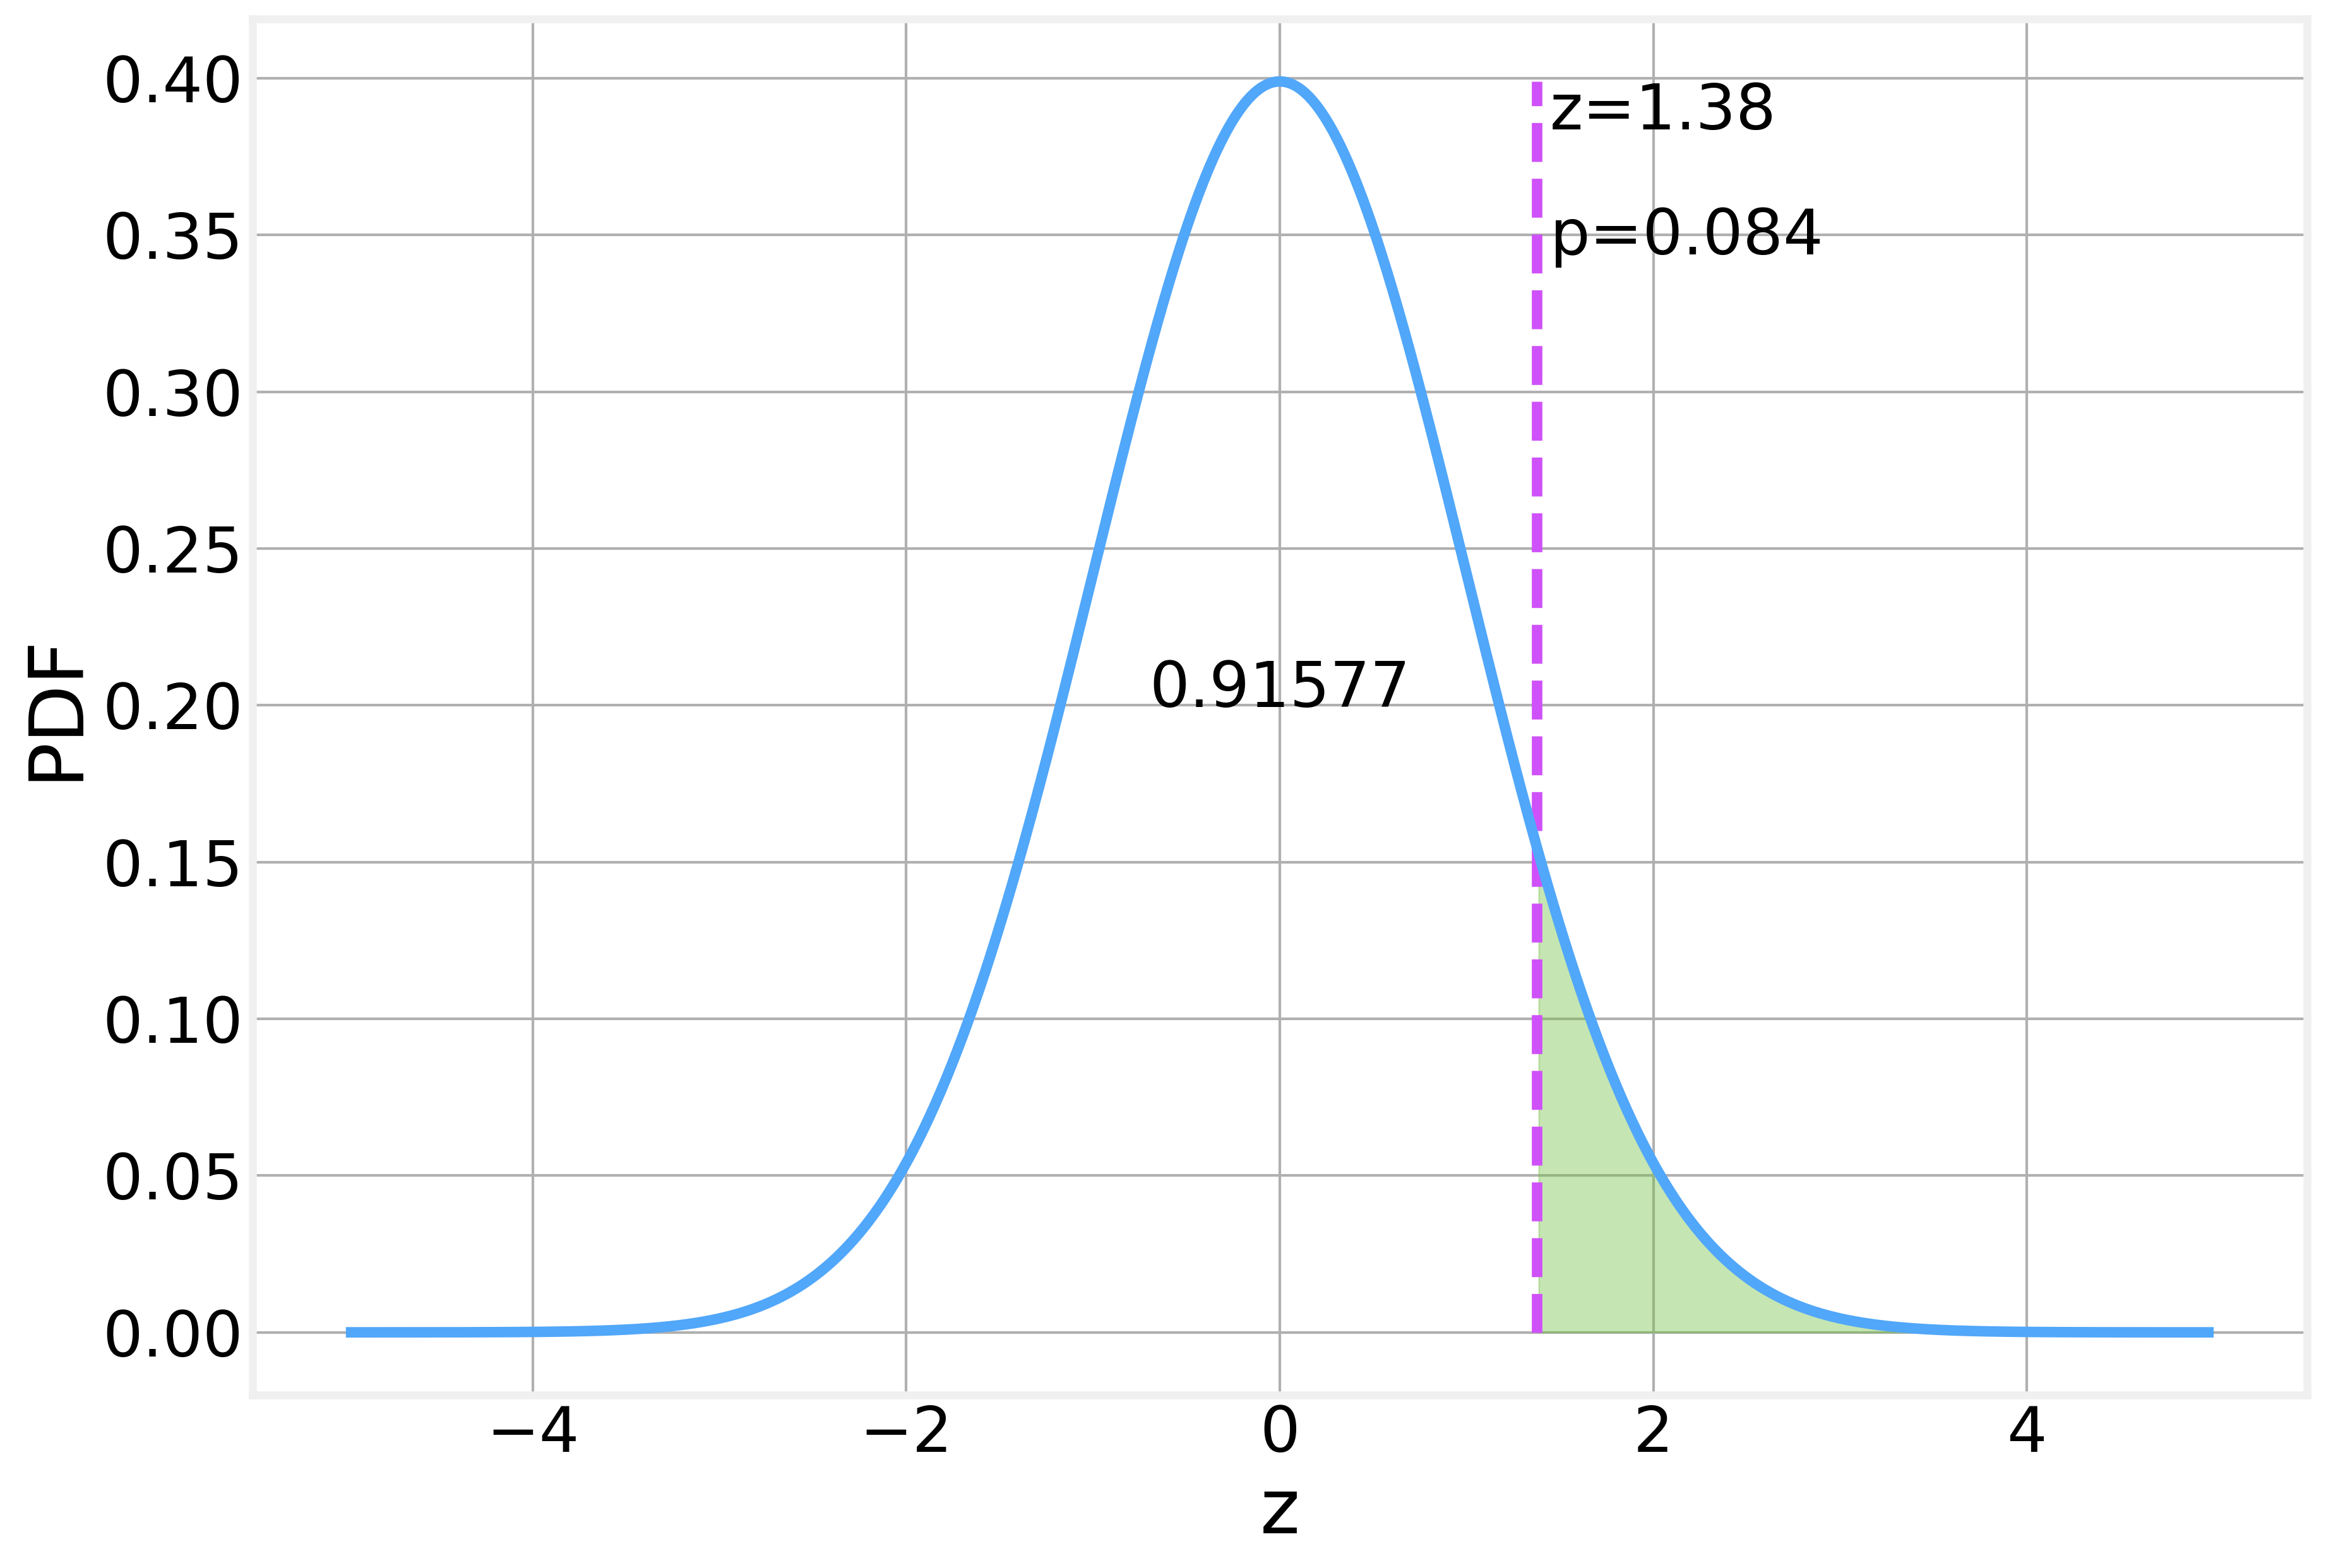

In [16]:
plot_zscore(Z)

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>